In [1]:
# Import installed modules
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load the SPICE kernel meta file
spiceypy.furnsh('kernel_meta.txt')

# Import our auxiliary sub-module that contains the apparent magnitude
# equation from last time
import sys
sys.path.insert(1, '../_auxiliary')
import asteroid_aux

In [2]:
# Set the Ceres NAIF ID
CERES_ID = 2000001

# Get the absolute magnitude and slope parameter (G) from NASA's small body
# database
# https://ssd.jpl.nasa.gov/sbdb.cgi#top
CERES_ABS_MAG = 3.4
CERES_SLOPE_G = 0.12

In [3]:
# Set a pandas dataframe. This dataframe will contain all computed parameters
ceres_df = pd.DataFrame([])

# Set a date-time range for the entire year in 1 Week steps
DATETIME_RANGE = pd.date_range(start='2020-01-01T00:00:00', \
                               end='2020-12-31T00:00:00', \
                               freq='1W')

# Append the UTC date-times to the Ceres' dataframe
ceres_df.loc[:, 'UTC_TIME'] = DATETIME_RANGE

# Add another column, where the date-time is converted to YEAR-DAYOFYEAR
ceres_df.loc[:, 'UTC_PARSED'] = DATETIME_RANGE.strftime('%Y-%j')

# Convert the date-time to Ephemeris Time
ceres_df.loc[:, 'ET_TIME'] = ceres_df['UTC_TIME'] \
                                 .apply(lambda x: spiceypy.utc2et(str(x)))

In [4]:
# Compute the distance between Ceres and the Sun and convert the resulting
# distance value given in km to AU
ceres_df.loc[:, 'DIST_SUN_AU'] = \
    ceres_df['ET_TIME'].apply(lambda x: \
        spiceypy.convrt( \
            spiceypy.vnorm( \
                spiceypy.spkgps(targ=CERES_ID, \
                                et=x, \
                                ref='ECLIPJ2000', \
                                obs=10)[0]), \
            'km', 'AU'))

# # Compute the distance between Ceres and the Earth and convert the resulting
# distance value given in km to AU
ceres_df.loc[:, 'DIST_EARTH_AU'] = \
    ceres_df['ET_TIME'].apply(lambda x: \
        spiceypy.convrt( \
            spiceypy.vnorm( \
                spiceypy.spkgps(targ=CERES_ID, \
                                et=x, \
                                ref='ECLIPJ2000', \
                                obs=399)[0]), \
            'km', 'AU'))

In [5]:
# Compute the phase angle between the Earth and the Sun as seen from Ceres
ceres_df.loc[:, 'PHASE_ANGLE_EARTH2SUN_RAD'] = \
    ceres_df['ET_TIME'].apply(lambda x: spiceypy.phaseq(et=x, \
                                                        target=str(CERES_ID), \
                                                        illmn='10', \
                                                        obsrvr='399', \
                                                        abcorr='NONE'))

# Convert the phase angle results to degrees (for plotting)
ceres_df.loc[:, 'PHASE_ANGLE_EARTH2SUN_DEG'] = \
    np.degrees(ceres_df['PHASE_ANGLE_EARTH2SUN_RAD'])

In [6]:
# Compute the apparent magnitude of Ceres
ceres_df.loc[:, 'APP_MAG'] = \
    ceres_df.apply(lambda x: \
        asteroid_aux.app_mag(abs_mag=CERES_ABS_MAG, \
                             phase_angle=x['PHASE_ANGLE_EARTH2SUN_RAD'], \
                             slope_g=CERES_SLOPE_G, \
                             d_ast_sun=x['DIST_SUN_AU'], \
                             d_ast_earth=x['DIST_EARTH_AU']), \
        axis=1)

In [7]:
# Determine the ecliptic coordinates of Ceres in longitude and ...
ceres_df.loc[:, 'ECLIP_LONG_RAD'] = \
    ceres_df['ET_TIME'].apply(lambda x: \
        spiceypy.recrad(spiceypy.spkgps(targ=CERES_ID, \
                                        et=x, \
                                        ref='ECLIPJ2000', \
                                        obs=399)[0])[1])

# ... latitude
ceres_df.loc[:, 'ECLIP_LAT_RAD'] = \
    ceres_df['ET_TIME'].apply(lambda x: \
        spiceypy.recrad(spiceypy.spkgps(targ=CERES_ID, \
                                        et=x, \
                                        ref='ECLIPJ2000', \
                                        obs=399)[0])[2])

# Convert the resulting values from radians to degrees
ceres_df.loc[:, 'ECLIP_LONG_DEG'] = \
    np.degrees(ceres_df['ECLIP_LONG_RAD'])

ceres_df.loc[:, 'ECLIP_LAT_DEG'] = \
    np.degrees(ceres_df['ECLIP_LAT_RAD'])

In [8]:
# What do we want to achieve? Well a sky plot with the path of Ceres would be
# nice. Scaling and colouring the individual positions based on the apparent
# magnitude would guide the eye. Remember: a smaller magnitude corresponds to a
# brighter object. Scaling a bright object smaller would be kind of
# contra-intuitive.

# Let's scale the scatter dot with the logic: smaller magnitude -> larger dot
# size
from sklearn import preprocessing

# Set a pre-scaled array, where the apparent magnitude is scaled w.r.t. the
# minimum value (maximum brightness)
PRE_SCALED = np.array(np.min(ceres_df['APP_MAG']) \
                      / ceres_df['APP_MAG'].values).reshape(-1, 1)

# Set an scikit-learn scaler ...
scaler = preprocessing.MinMaxScaler()

# .. and fit it based on the pre-scaled data
scaler.fit(PRE_SCALED)

# Transform now the pre-scaled data from 0 to 1 ...
marker_pre_scale = scaler.transform(PRE_SCALED)

# ... and multiply it by 50. The resulting array is used to set the marker
# size for the plot
marker_scale = marker_pre_scale * 50

# Append the marker size array to the Ceres dataframe
ceres_df.loc[:, 'PLOT_MARKER_SIZE'] = marker_scale

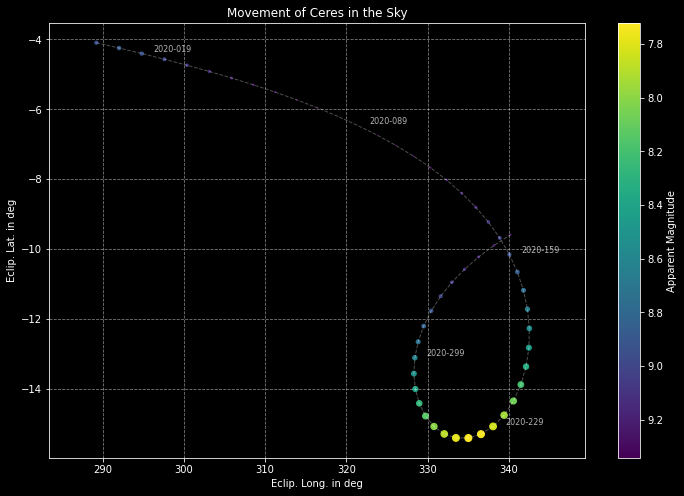

In [9]:
# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Set a colormap for the scatter plot
cm = plt.cm.get_cmap('viridis_r')

# Plot the coordinates of Ceres as a scatter plot. Set a colour and marker
# size accordingly to the apparent magnitude
plt.scatter(x=ceres_df['ECLIP_LONG_DEG'], \
            y=ceres_df['ECLIP_LAT_DEG'], \
            c=ceres_df['APP_MAG'], \
            alpha=1, \
            s=ceres_df['PLOT_MARKER_SIZE'], \
            marker='o', \
            cmap=cm)

# Add a white dashed path line, to improve the readability of the plot
plt.plot(ceres_df['ECLIP_LONG_DEG'], \
         ceres_df['ECLIP_LAT_DEG'], \
         marker=None, \
         linestyle='dashed', \
         color='white', \
         alpha=0.3, \
         lw=1)

# To get a better feeling how Ceres moves along the sky during the year, we
# add some date-time text fields along the path
for date_str, ceres_x, ceres_y in ceres_df[['UTC_PARSED', \
                                            'ECLIP_LONG_DEG', \
                                            'ECLIP_LAT_DEG']].values[2::10]:

    # Use matplotlib's annotate functionality to add date-time stamps along
    # the sky trajectory
    plt.annotate(date_str,
                 (ceres_x, ceres_y),
                 textcoords="offset points",
                 xytext=(12, 2),
                 ha='left',
                 color='white', \
                 alpha=0.7, \
                 fontsize=8)

# Set a grid
plt.grid(True, linestyle='dashed', alpha=0.5)

# Get the axes
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')

# Add a colorbar
cbar = plt.colorbar()
cbar.ax.invert_yaxis()
cbar.set_label('Apparent Magnitude')

# Set long. / lat. labels
plt.xlabel('Eclip. Long. in deg')
plt.ylabel('Eclip. Lat. in deg')

# Set an x-lim range
plt.xlim(np.min(ceres_df['ECLIP_LONG_DEG'])*0.98, \
         np.max(ceres_df['ECLIP_LONG_DEG'])*1.02)

# Set a title
plt.title('Movement of Ceres in the Sky')

# Save the figure
plt.savefig('ceres_sky_map_movement.png', dpi=300)